.. _main_calculation_immigrant:

# Main Calculation Immigration

In order to immigrate existing CRYSTAL17 calculations,
the :py:mod:`aiida_crystal17.immigration` module has been
created to take a ``.d12`` and ``.out`` file set
and replicate a ``crystal17.main`` calculation:

.. note::

    This approach may be subject to change, 
    if a general approach is developed for immigrant calculations
    (see [this ongoing issue](https://github.com/aiidateam/aiida_core/issues/1892)).


In [1]:
from aiida import load_profile
profile = load_profile()
import os
from aiida_crystal17.tests import TEST_DIR
from aiida_crystal17.immigration.create_inputs import populate_builder
from aiida_crystal17.immigration.cry_main import migrate_as_main
from aiida_crystal17.common import display_json
from aiida_crystal17.graph import Graph
from aiida.orm import Code, FolderData

:py:func:`aiida_crystal17.immigration.create_inputs.populate_builder`
will create an input builder for the `crystal17.main` calculation,
from a `FolderData` node, populated with the files, and a `Code` node.

In [25]:
inpath = os.path.join(TEST_DIR, "input_files", 'nio_sto3g_afm_opt.crystal.d12')
outpath = os.path.join(TEST_DIR, "output_files",
                       'nio_sto3g_afm_opt.crystal.out')

folder = FolderData()
folder.put_object_from_file(inpath, "main.d12")
folder.put_object_from_file(outpath, "main.out")

code = Code.objects.get(label="crystal17.basic-mock_runcry17@localhost")

builder = populate_builder(
    folder, 
    input_name="main.d12", output_name="main.out",
    code=code)

display_json(builder)

```json
{
  "metadata": {
    "options": {}
  },
  "basissets": {
    "Ni": [
      "uuid: cc07c606-1367-47db-a54a-245a2fa785d9 (pk: 438)"
    ],
    "O": [
      "uuid: 8ff5a170-ee9f-452a-a9ef-1afdf33272a8 (pk: 439)"
    ]
  },
  "parameters": [
    "uuid: f1c8ac66-18d7-419e-ba72-18ca28a49aff (unstored)"
  ],
  "structure": [
    "uuid: 5db55528-f00e-4788-b391-d020c9cc4be0 (unstored)"
  ],
  "symmetry": [
    "uuid: acb10d45-3e66-4582-a0b0-ff444221ccf5 (unstored)"
  ],
  "kinds": [
    "uuid: a7ab07ff-1ab0-4647-a084-ff62e49a3bda (unstored)"
  ],
  "code": [
    "Remote code 'crystal17.basic-mock_runcry17@localhost' on localhost,",
    "pk: 7, uuid: 6a3db008-b5ab-4308-baf9-d18a39ca4ad5"
  ]
}
```

:py:func:`aiida_crystal17.immigration.cry_main.migrate_as_main`
creates a `CalcJobNode` and uses the above function,
and the `crystal17.main` parser, to create and attach incoming and outgoing nodes,
replicating a full calculation.

In [26]:
folder = FolderData()
folder.put_object_from_file(inpath, "main.d12")
folder.put_object_from_file(outpath, "main.out")
calc_node = migrate_as_main(
    folder, code,
    input_name='main.d12', output_name='main.out', 
    resources=(('num_mpiprocs_per_machine', 1), ('num_machines', 1)), 
    withmpi=True, store_all=True
)
calc_node

<CalcJobNode: uuid: ba006c98-a69d-41d6-8266-4028b968ce0b (pk: 460) (crystal17.main)>

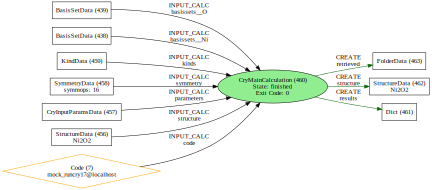

In [27]:
graph = Graph(graph_attr={'size': "6,8!", "rankdir": "LR"})
graph.add_node(calc_node)
graph.add_incoming(calc_node, annotate_links="both")
graph.add_outgoing(calc_node, annotate_links="both")
graph.graphviz

In [28]:
calc_node.attributes

{'exit_status': 0,
 'input_file_name': 'main.d12',
 'output_main_file_name': 'main.out',
 'withmpi': True,
 'resources': {'num_machines': 1, 'num_mpiprocs_per_machine': 1},
 'immigrated': True,
 'process_label': 'CryMainCalculation',
 'process_state': 'finished'}